# Collaborative Auto-encoder

## Code 

**Repo**:  https://github.com/DGeisz/competitive_ae/tree/collaborative  
**Branch**: collaborative  
**Commit**: bc14cf9b8b27057cfb7b

**Metric repo**: https://github.com/DGeisz/MNIST-Competive-Classification-Metric/tree/collaborative  
**Metric branch**: collaborative  
**Commit**: 126d703d92916430d202fb84

## Intro

* **Date**: 11/20/2020
* **What**: This architecture is a collaborative auto-encoder, in which the output "prototypes" learned by neurons are compounded rather than averaged.  This allows neurons to work together to reconstruct an image, which allows each neuron to specialize in recreating a small portion of the output, rather than trying to recreate the entire output.  
* **Why**: By letting neurons collaborate, each neuron can attempt to learn one highly correlated artifact from the dataset and reproduce that artifact when it is detected, relying on other neurons to provide the other missing "pieces of the puzzle" to fully reconstruct an input. If this properly occurs, then each neurons output should be quite uncorrelated, and almost act like an independent vector component which can be used in conjunction with other components to reconstruct the input.
* **Hopes**: I cooked up [this](../11_20_2020_metric_mnist_collaborative_classification) metric specifically for collaborative models, and I have hopes that this metric provide a superior classification of the dataset than the 60% accuracy classifications the other "winner-takes-all" (wta) competitive metric I was using provides.
* **Limitations**: While this certainly isn't principal component analysis, it's doing something pretty similar, in that this architecture learns specific important vectors and then sums those vectors up in a linear fashion.  The vectors don't necessarily have to be orthogonal, and as far as I can tell from previous experiments, the vectors change if you allow more to be added to the party, which doesn't really feel like PCA.  However, in the spirit of the great Irfan Siddiqi, the reason this architecture is most suspect is because it's so frikin linear.  It's very possible it won't do super well in classifying inputs because it's so incredibly linear.  So I may need to figure out how to add some non-linearities into the mix for these collaborative networks.

## Technicals

Here's how the neuron calculates its output values, it's reconstruction, and learns its weights.  Let $w_{ij}$ the weight of the $j^{th}$ synapse of the $i^{th}$ neuron.  Let $q_i$ be the input of the $i^{th}$ pixel, and $p_i$ be the reconstruction value of the $i^{th}$ pixel.  Let $o_i$ be the output of the $i^{th}$ neuron.  Let $m$ be the number of pixels, and $n$ be the number of neurons. Finally, let $\alpha$ be the learning constant.  Then we have: 

$$
o_i = \frac{\sum_{j = 0}^{m} q_j \cdot w_{ij}}{\sum_{j = 0}^{m} w_{ij}} $$

$$
p_t = \sum_{i = 0}^{n} o_i \cdot w_{it}
$$

$$
\Delta w_{ij} = - o_t \cdot(p_i - q_i) \cdot\alpha
$$

## Analysis Dialog

So this algo is pretty good, but not fantastic.  Even with the improved metric, I can't seem to get an accuracy much better than 67% classifying mnist.  But anyway, let's talk about how this algo is good. First of all, it's fast.  Way faster than [this one](../11_19_2020_experiment_prototype_ae), which took literally 1.75 hours to train 100 neurons on 60,000 images.  This algo trains 100 neurons on 60,000 images in about 25 seconds.  Great.  So my thought that treating weighted averages as constant when taking gradients worked fantastically.  

Now then, let's talk about the prototypes this bad boi learns.  Here's the model trained on 60,000 images for 5 epochs.

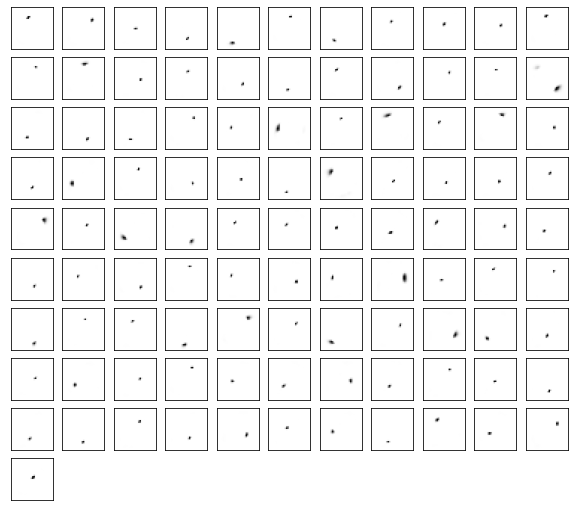

In [29]:
num_imgs = len(five_epochs)
side_len = int(((num_imgs ** 0.5) // 1.0) + 1)

plt.figure(figsize=(10, 10))
for i, img in enumerate(five_epochs):
    plt.subplot(side_len, side_len, i + 1)

    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap="Greys")

plt.show()

Cool.  However, to better understand what the network is doing, here are the weight prototypes that the network learns when it's trained on 5 neurons.

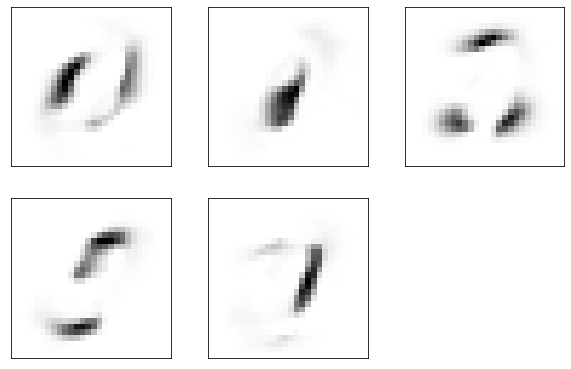

In [34]:
num_imgs = len(five_neurons)
side_len = int(((num_imgs ** 0.5) // 1.0) + 1)

plt.figure(figsize=(10, 10))
for i, img in enumerate(five_neurons):
    plt.subplot(side_len, side_len, i + 1)

    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap="Greys")

plt.show()

So you'll notice that when there are fewer neurons, the network learns more complicated shapes.  This illustrates what this network is doing when it trains.  If there are $n$ neurons, the network tries to find the $n$ vectors which are most useful in reconstructing data.  You'll notice that there's some overlap between the learned weight prototypes.  This shows that these vectors aren't necessarily orthogonal, which is the distinction between this method and something like PCA.  If there are $n$ neurons, this network makes the assumption that any piece of data can be reconstructed from a linear combination of $n$ principal vectors.  I might go so far as to call this principal vector analysis.  

Anyway, as I mentioned in the limitations section, this is all very horrifyingly linear. At the same time, linear systems are nicely behaved (honestly too nicely behaved).  Now then, let's talk more about this architecture's classification abilities with the mnist metric currently in use.  

For the first dataset I mentioned (100 neurons, 60,000 images, 5 epochs), using the above classification method, the network got a classification accuracy of 67.29%.  Better than my other novel algos.  However, to understand why it's not doing any better than this, let me spill some more data.

I don't want to go through the hassle of serializing this data because that annoying, but check this out: 

**Data**


Misclassifications:  [67, 3, 581, 374, 193, 629, 169, 191, 800, 468]


mis class for 0,  
[0, 8, 1, 7, 3, 4, 31, 13, 0, 0]


mis class for 1,  
[0, 0, 0, 1, 0, 0, 2, 0, 0, 0]


mis class for 2,  
[26, 436, 0, 10, 32, 0, 34, 33, 8, 2]


mis class for 3,  
[7, 299, 9, 0, 0, 7, 9, 30, 2, 11]


mis class for 4,  
[1, 122, 0, 0, 0, 0, 24, 6, 0, 40]


mis class for 5,  
[39, 262, 1, 183, 29, 0, 33, 52, 3, 27]


mis class for 6,  
[15, 107, 6, 1, 33, 6, 0, 1, 0, 0]


mis class for 7,  
[4, 161, 5, 0, 11, 0, 1, 0, 0, 9]


mis class for 8,  
[13, 603, 3, 61, 27, 6, 28, 36, 0, 23]


mis class for 9,  
[14, 145, 5, 10, 123, 2, 6, 163, 0, 0]

**End of Data**

The first line shows the number of times each class of digit was misclassified, and the subsequent lines are the number of times the classification was mistaken for each other type of number.

As is pretty evident from this data, 1 is almost never misclassified, which other digits are mistaken for 1s all the time.  The underlying assumption of this classification metric is that certain principal vectors are more important reconstruction certain digits than others.  However, for something like the number 1, which goes all over the place throughout the image, a wide variety of principal vectors are used for recreating 1s.  There are just many different types of 1s because it's the most flexible digit, so it throws this metric off.

Put in a different way, because the neurons are largely learning principal components, the neurons aren't learning the "shapes" of the different digits, which means this single layer is doing a pretty poor job at classification (relative to the Diehl SNN, for example, which does a very good job learning digit prototypes).  

Now, this is actually interesting.  You'll notice that this architecture does actually learn more complicated "shapes" if it's forced to learn only several principal vectors.  Perhaps an interesting architecture to try would be a multi-layer network with progressively smaller layers.  The first layers would find only the most important vector artifacts, and the last layers would then be forced to piece these artifacts together into correlated shapes.  These shapes might then be more in line with more complicated shapes in the inputs than is feasible with only one layer of principal vectors.  

Also, let me share a couple other compelling things about this architecture.  With only 10 neurons, the network gets an mnist accuracy of 60% which is pretty good, given the limitations I've discussed.  (Also, you can assume that if I don't give more specifications, I'm training on 60,000 images, testing on 10,000 images, and using a learning constant of 0.001).  With 50 neurons, the network gets an accuracy of 66%.  Dang.  That means we only get about a 1% increase in classification accuracy with another 50 neurons?  Crazy.  That only furthers my idea of having a good method for allocating neurons based on where they'd most useful is a good idea.  In the present case, it might be a good idea to allocate neurons based on reconstruction accuracy.

On a different note, the network learns principal vectors pretty quickly.  I've been talking about learning weights using 60,000 images so far, (except for the one case where I trained on 5 epochs), but training 100 neurons on 10,000 images yields an mnist accuracy of 58%, which is still doing quite well.  Trained on only 1000 images, the network still gets 54% mnist accuracy.  Granted, here are what the prototypes look like after 1000 images:


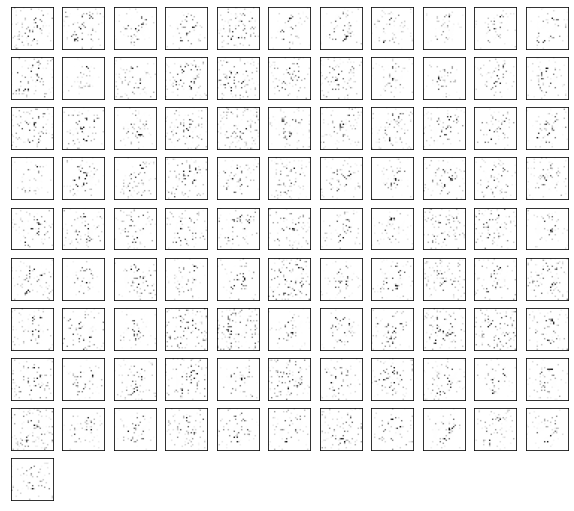

In [39]:
num_imgs = len(low_img)
side_len = int(((num_imgs ** 0.5) // 1.0) + 1)

plt.figure(figsize=(10, 10))
for i, img in enumerate(low_img):
    plt.subplot(side_len, side_len, i + 1)

    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap="Greys")

plt.show()

So clearly these aren't the best de-correlated principal vectors, but they're certainly not random.  All this is to say, the network learns principal vectors pretty rapidly.  The fact that the network barely does better on the mnist metric after 5 epochs of 60,000 images than 1 epoch also means that the network learns a fairly stable set of principal vectors that aren't prey to over-fitting.

The ultimate goal is to have a distributed network that continues learning forever (incremental learning, as the kids call it), so you certainly don't want an architecture that's over-fitting after a meager 60,000 images. 

I could go down a couple different avenues here, like visually showing some reconstructions, but there's so much to improve upon, that I think I'm just going to move on to new experiments.

Oh wait, one last thing.  I'm not entirely sure why, but if you use a learning constant much greater than 0.001, the network goes berserk and NaNs all the weights, which is obviously no good.  If it becomes evident that this sort of architecture is the way to go in moving forward in different higher level tasks, then I'll have to look into that.  For the time being, no reason to use a different learning constant than 0.001.

## Conclusions

I had high hopes for this architecture, and while it was somewhat disappointing, there's certainly a lot to learn here.  First of all, I'll reiterate that I'm quite happy with how quickly this network trains.  Ain't nobody got time for an architecture that trains slowly.  

Second of all, it appears that principal vector extraction (what this network is doing) is useful, but not necessarily by itself.  It finds the most important parts of the input, but it doesn't say much about how those parts fit together.  This very fact is why it seems uber difficult to get a accuracy with the mnist metric above 67%.  Still, I shouldn't minimize that this is better than why other networks so far.  Still, there seems to be a lot of improvement that could take place.  

Given the intense linearity of this network, it'd be interesting to see how this architecture measures up against PCA.  Maybe I'll look into papers on that.

One last thing.  This experiment showed me how important it is for a network to capture the structure of the input data in its prototypes.  The extreme specialization of each neuron means that it has no idea what is going on in other parts of the input, which means it's not attuned to different complex structures in the input.  Thus while it makes this sort of architecture a good candidate for basic dimensionality reduction, the individual neurons don't actually say much about the overall structure of the input like a competitive architecture might, like the Diehl SNN.  

Again, I should mention that if this architecture is forced to learn a restricted number of principal vectors, then it captures more interesting shapes.  Again, I think this could be utilized in a deep architecture.

## Next steps

There are two main experiments that I'm really interested in running based on the results of this experiment and my other research.  

The first experiment shouldn't come as much of a surprise.  I want to make a multi-layer network using the same types of neurons I used in this experiment.  As I already mentioned, I think the first layers would find the most important aspects of the input data, and the last layers would get tuned into particular high level shapes.  I suppose I could look up multi-layer PCA networks, which might get similar results as this network.  Anyway, I think it might get a much better accuracy than just a single layer.  Also I could put like 40 neurons on the first layer, 30 on the second, and 20 of the third, and still have less than 100 neurons.  It'd be cool if that got a better accuracy than the smallest Diehl network, which had 100 neurons.  Basically, I'm hell-bent on beating Diehl.  

The second experiment is a return back to my roots.  I'm getting irritated at how well SNNs seem to work.  But they're just sooo slow.  I want to make an architecture that does effectively the same thing as them, but uses analog digits to be far more efficient.  My endeavors from the past three weeks have shown me the true evil of weighted averages in neural nets, and I think I've actually come up with a competitive network that should effectively do the same thing as the Diehl network without relying on any notion of a weighted average.  As always, the architecture I'm thinking of is highly distributable, so hello parallel FPGA implementations.  Anyway, that's all I'm going to say for now about that.

This was a good experiment.

# Data

In [ ]:
import matplotlib.pyplot as plt 
import pickle

In [28]:
five_epochs = pickle.load(open("data/important.pickle", "rb"))

In [31]:
five_neurons = pickle.load(open("data/five_neurons.pickle", "rb"))

In [38]:
low_img = pickle.load(open("data/low_img.pickle", "rb"))